In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.figsize'] = [12, 8] 
plt.rcParams.update({'font.size': 25})


A tutorial on analysing the inference of effective population size over time ($N_e(t)$) or coalescence times from PSMC+. 

Last updated 21st December 2023. 

# Inference of $N_e(t)$

It is easy to plot the inference of PSMC+. Suppose your output files are: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/CLM_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/GBR_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/JPT_final_parameters.txt<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/home/trevor/PSMCplus_tutorial/inferencedata/BEB_final_parameters.txt<br>
<br>
(Inference here used D=64, b=100, mu_over_rho_ratio=1.5, its=30,spread_1=0.05, spread_2=50)<br><br>
Then you can do: 

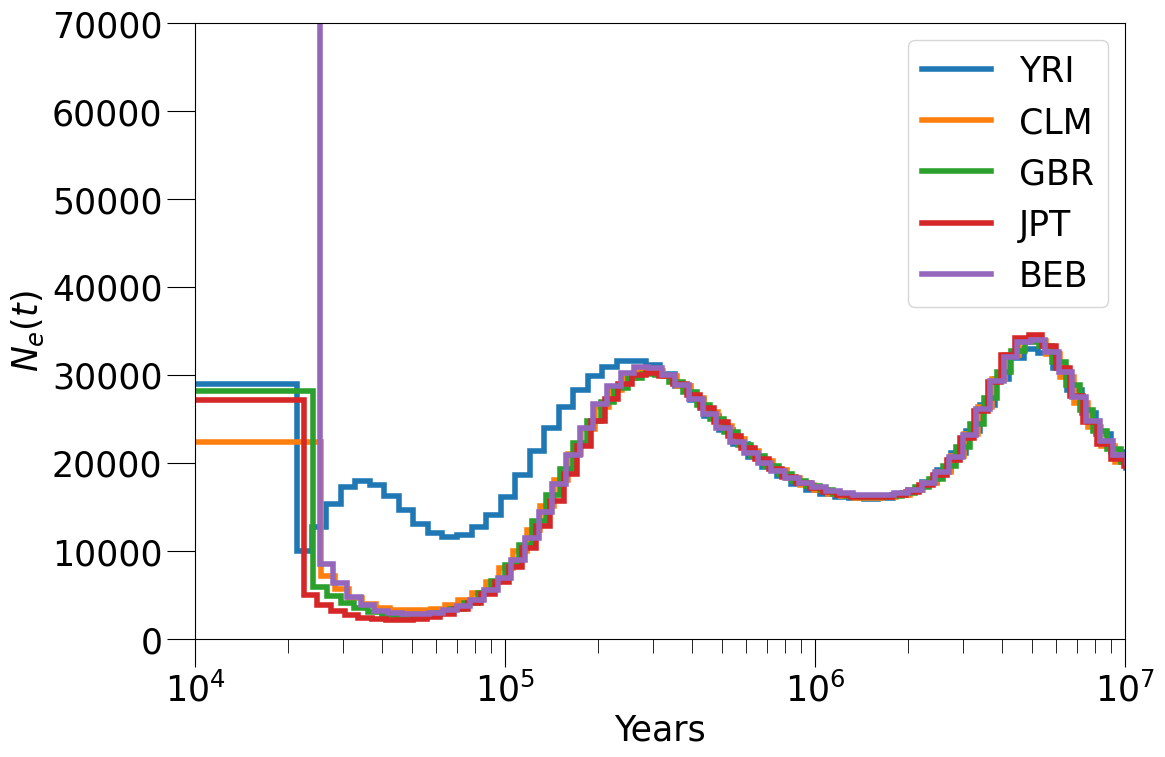

In [20]:
mu = 1.25e-08
gen = 29

for population in ['YRI','CLM','GBR','JPT','BEB']:
    final_params_file = f'/home/trevor/PSMCplus_tutorial/inferencedata/{population}_final_parameters.txt'
    final_params = np.loadtxt(final_params_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=population,linewidth=4,linestyle="solid",baseline=None)

plt.xlim(1e+04,1e+07)
plt.ylim(0,7e+04)
plt.xscale('log')
plt.ylabel('$N_e(t)$')
plt.xlabel('Years')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.legend()
plt.show()


# Inference of coalescence times across the genome

Suppose we want to decode one of the YRI chromosomes as used in inference above. Ideally, we want to use the inferred $N_e(t)$ parameters to do this. We can do this by extracting the inverse coalescence parameters from the "final_parameters.txt" file:  

In [52]:
# extract parameters from inference

final_parameters = np.loadtxt('/home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt') # load final parameters
ztheta = !cat /home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt | grep theta # get theta from file
theta = float(ztheta[0].split(' ')[-1]) 
zrho = !cat /home/trevor/PSMCplus_tutorial/inferencedata/YRI_final_parameters.txt | grep rho # get rho from file
rho = float(zrho[0].split(' ')[-1]) 
lambda_parameters = final_parameters[:,2]*theta/4 # get lambda parameters (the inverse coalescence rates) in coalescent units
lambda_parameters_string = ",".join([str(i) for i in lambda_parameters]) # make it a comma separated string
infile = '/home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20.mhs'
outfile = '/home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20_decoding.txt.gz'

In [63]:
# set the command line string, using same parameters as inference. Save every 1000 base pairs only (b*decode_downsample=1000)
commandline = f'python /home/trevor/PSMCplus/PSMCplus.py -in {infile} -D 64 -b 100 -spread_1 0.05 -spread_2 50 -theta {theta} -rho {rho} -lambda_A_fg {lambda_parameters_string} -o {outfile} -decode -decode_downsample 10'

In [64]:
!{commandline} # this took my laptop about 25 seconds


Running PSMCplus; last updated 230925ymd; v1.1
Command line: python /home/trevor/PSMCplus/PSMCplus.py -in /home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20.mhs -D 64 -b 100 -spread_1 0.05 -spread_2 50 -theta 0.0009998188109354466 -rho 0.0004119061061395524 -lambda_A_fg 0.6906809583208723,2.0138872921537407,1.5794250715012357,1.3046549151597842,1.1615605116804073,1.1160343160593473,1.1453122849912245,1.2353473745554213,1.3726054623506154,1.5305165445696525,1.6640677378925508,1.7265897183287557,1.695479811768646,1.5823176724990717,1.4191558519657856,1.2406487568168385,1.0751755208725366,0.93859280739646,0.8349754731539164,0.7600899785923266,0.7073090567763702,0.6706845746634192,0.6467080421091825,0.6342547255131511,0.6330082149976504,0.642934892289605,0.6642542859697635,0.6964194947949228,0.7384775034777215,0.7889033637403136,0.8454410126893845,0.9055748649719878,0.9667574071617051,1.027278235385956,1.0842111956074834,1.1359728669869584,1.1804213819282643,1.2159637472576523,1.24153833

We can either visualise the posterior distribution with a heatmap, or take the posterior mean and see how this changes across the genome. 

In [122]:
decoding = np.loadtxt('/home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20_decoding.txt.gz') # load the decoding file
positions = decoding[0,:] # get position array
posteriors = decoding[1:,] # get posteriors

time_coalescent_string = !zcat /home/trevor/1KGP_data/230213/YRI/NA18488/mhs/chr20_decoding.txt.gz | head -6 | tail -1 # get 
time_coalescent = np.array([float(i) for i in time_coalescent_string[0].split(' ')[1].split(',')])
N = theta/(4*mu) # get N
time_years = time_coalescent*2*N*gen # get time in years
time_years_midpoints = np.array([(time_years[i]+time_years[i+1])/2 for i in range(0,64)]) # get the midpoints of the time boundaries

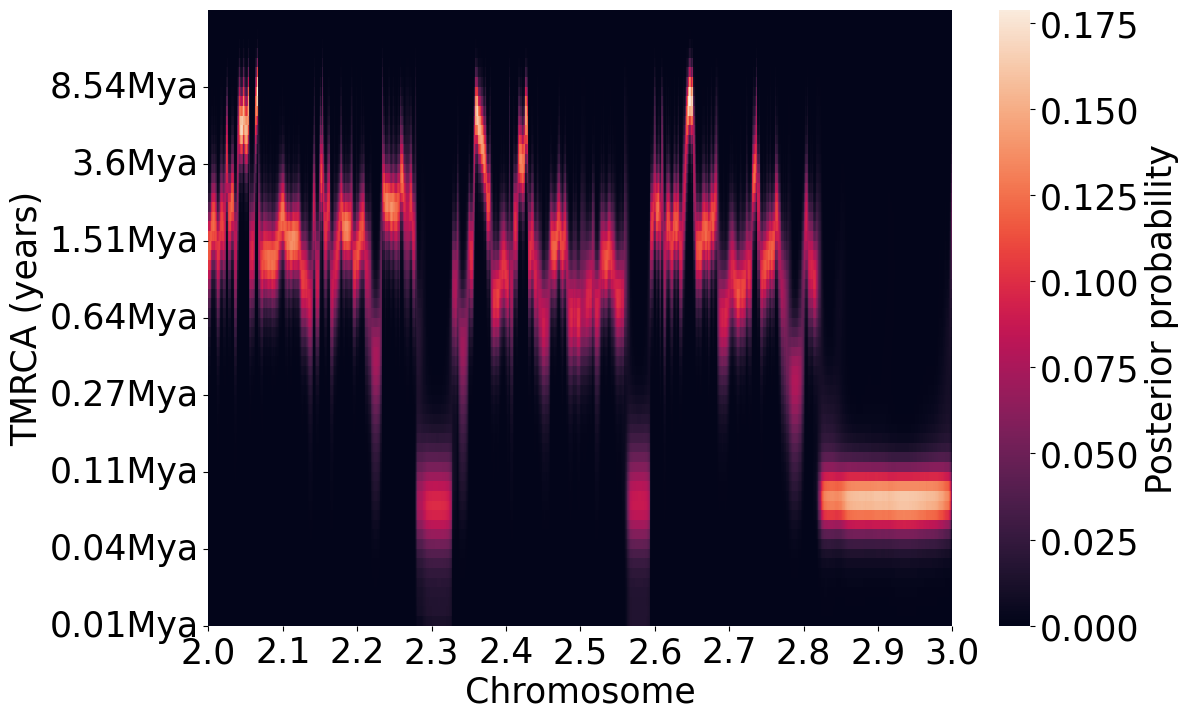

In [176]:
# heatmap 

start = 2000
end = 3000
ax = sns.heatmap(posteriors[:,start:end],cbar_kws={'label': 'Posterior probability'})
ydom = [i*8 for i in range(0,8)]
yticks_labs = [f'{str(int(time_years_midpoints[jj]/1e+04)/100)}Mya' for jj in ydom]
zxticks_labs = np.linspace(position[start],position[end],11)
xticks_labs = [str(i/1e+06) for i in zxticks_labs]
xdom = np.linspace(0,end-start,11)

ax.set_yticks(ticks=ydom,labels=yticks_labs,rotation='horizontal')
ax.set_xticks(ticks=xdom,labels=xticks_labs,rotation='horizontal')
ax.set_xlabel('Chromosome')
ax.set_ylabel('TMRCA (years)')

ax.invert_yaxis()

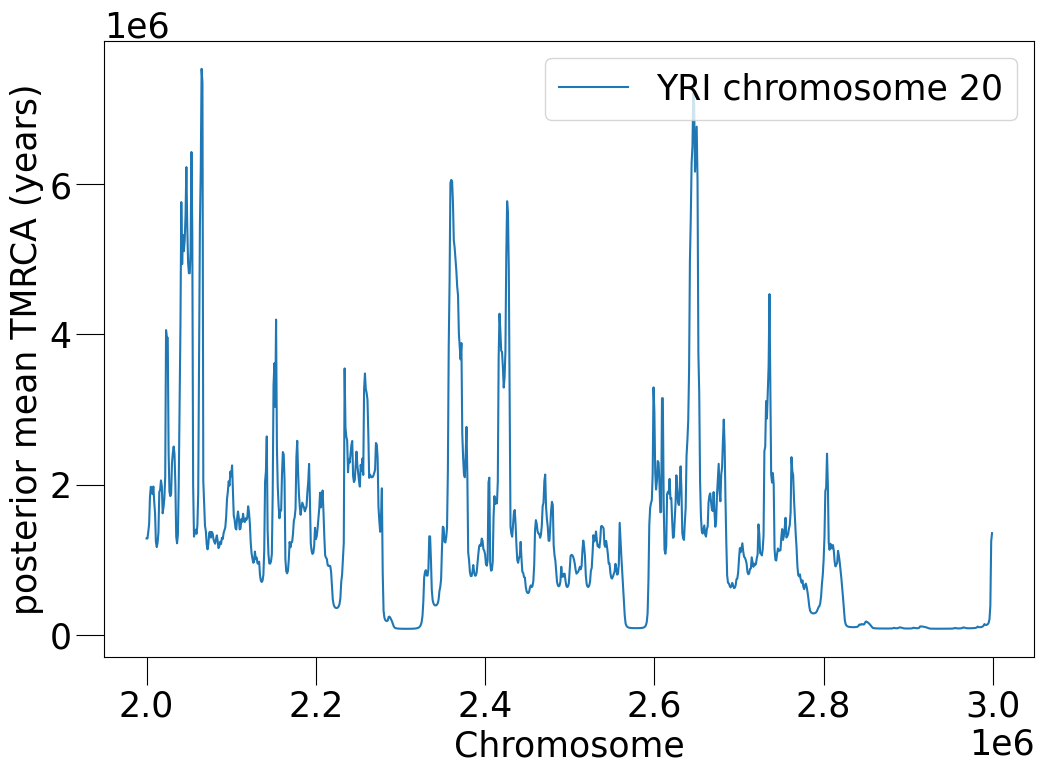

In [120]:
# posterior mean

posteriormean = sum(posteriors*time_years_midpoints[:,np.newaxis])
plt.plot(positions[start:end],posteriormean[start:end],label='YRI chromosome 20')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.xlabel('Chromosome')
plt.ylabel('posterior mean TMRCA (years)')
plt.legend()

# Varying mutation rate

PSMC+ enables a user to provided a map of varying coalescence rates across the genome. The local coalescent rate may change either do to selection or mutation rate variation. Here I provide examples of how the functionality works

In [9]:
import msprime 


def write_mhs(pos,filename,chrom):
    # pos is index of hets
    # chrom is int
    current_chr = f'chr{chrom}'
    diff_pos = pos[1:] - pos[0:-1]
    SSPSS = np.concatenate(([pos[0]] ,diff_pos))
    gt = ['01']*len(pos)
    chr_label = [current_chr]*len(pos)

    with open(filename,'w') as f:
        lis=[chr_label,pos,SSPSS,gt]
        for x in zip(*lis):
            f.write("{0}\t{1}\t{2}\t{3}\n".format(*x))
    print(f'\twritten mhs file to {filename}')
    return None

def write_scaled_R_map(chrom,scaled_ratemap,filename):
    f = open(filename, "w")
    for i in range(0,len(scaled_ratemap)):
        line=f'chr{chrom}\t{int(scaled_ratemap[i,0])}\t{int(scaled_ratemap[i,1])}\t{scaled_ratemap[i,2]}\n' # chrom, left, right, rate
        f.write(line)
    f.close()
    print(f'saved scaled rate map to {filename}')
    return None

def get_coal_data(sim):
    tmrca_data = [] # first column is index, second column is span of tree, third column is tMRCA
    tmrca_data = np.zeros(shape=(sim.get_num_trees(),3))
    index = 0
    for tree in sim.trees():
        tmrca_data[index,0] = tree.index
        tmrca_data[index,1] = tree.interval[1]
        try:
            t = tree.time(tree.mrca(0,1))
        except:
            t=0 # if no data in recombination map (rate=NaN), then fails
        tmrca_data[index,2] = t
        # print(tree.draw(format="unicode"))
        index += 1
    return tmrca_data


def time_intervals_fcn(D,spread_1,spread_2,final_T_factor=None): 
    T = [0]
    if final_T_factor is not None: # last boundary is a factor of second-to-last boundary
        for i in range(0,D-1): 
            T.append( spread_1*np.exp( (i/D)*np.log(1 + spread_2/spread_1) - 1))
        T.append(T[-1]*final_T_factor) # append  large last tMRCA to represent infinity
    else: # last boundary follows the sequence
        for i in range(0,D): 
            T.append( spread_1*np.exp( (i/D)*np.log(1 + spread_2/spread_1) - 1))

    T_np = np.array(T)
    return T_np


## Decoding

In [3]:
# create mutation map (a mutation rate that varies across the genome, arbitrary parameters)

L = 1e+07
r = 1e-08

mean_mu = 1.25e-08
a=1
b=3


# visulaise mutation map density
# xdom = np.arange(0,1,0.01)
# pdf = beta.pdf(xdom,a,b)
# plt.plot(xdom,pdf)

lengthscale = 1e+05
breakpoints = [0]
qdist= 0
while qdist<L:
    qdist += np.random.exponential(scale=lengthscale)
    breakpoints.append(qdist)
breakpoints[-1]=L

mu = mean_mu

num_mu_samples = len(breakpoints)
mu_samples = np.random.beta(a,b,size=len(breakpoints)-1)
mu_samples = mu_samples/((a/(a+b))/mean_mu)
mutationratemap = msprime.RateMap(position=breakpoints, rate=mu_samples)
mu_over_r_yvar = np.mean(mu_samples)/r

np.savetxt('/home/trevor/testing_varyingmuPSMCplus/mu_samples_230909.txt',mu_samples)
np.savetxt('/home/trevor/testing_varyingmuPSMCplus/breakpoints_230909.txt',breakpoints)

In [5]:
# write the mutation map to a file that PSMCplus can use
# it is a bed file; 1st column is chrom, 2nd column is start position, 3rd column is end position, 4th column is the rate between the start and end (2nd and 3rd column, respectively)

starts = mutationratemap.left
ends = mutationratemap.right
rates = mutationratemap.rate/mean_mu
scaled_ratemap = np.zeros(shape=(len(starts),3))
scaled_ratemap[:,0] = starts
scaled_ratemap[:,1] = ends
scaled_ratemap[:,2] = rates
write_scaled_R_map(20,scaled_ratemap,f'/home/trevor/testing_varyingmuPSMCplus/myratemap_230909.txt')


saved scaled rate map to /home/trevor/testing_varyingmuPSMCplus/myratemap_230909.txt


In [10]:
# simulate from msprime with a constant mutation rate and a varying mutation rate (from the mutation map in the above cell)

N_size = 2e+04
chrom=20
ztheta = mean_mu*4*N_size
demography = msprime.Demography()
demography.add_population(name="human", description="standard human pop", initial_size=N_size)
demography.add_population_parameters_change(time=0, initial_size=N_size)
sim = msprime.sim_ancestry(samples=[msprime.SampleSet(num_samples=2, ploidy=1,population='human',time=0)],demography=demography,recombination_rate=r,sequence_length=L)
msim_nvar = msprime.sim_mutations(sim, rate=mean_mu) # add mutations
msim_yvar = msprime.sim_mutations(sim, rate=mutationratemap) # add mutations
msprime_hets_nvar = np.array([int(np.rint(var.site.position)) for var in msim_nvar.variants() if var.genotypes[0]!=var.genotypes[1]])
msprime_hets_yvar = np.array([int(np.rint(var.site.position)) for var in msim_yvar.variants() if var.genotypes[0]!=var.genotypes[1]])

mhsfilename_nvar = f'/home/trevor/testing_varyingmuPSMCplus/constpop_mu{mu}_r{r}_L{L}_N{N_size}_2300909_nvar.mhs'
mhsfilename_yvar = f'/home/trevor/testing_varyingmuPSMCplus/constpop_mu{mu}_r{r}_L{L}_N{N_size}_2300909_yvar.mhs'

coaldataname = f'/home/trevor/testing_varyingmuPSMCplus/constpop_mu{mu}_r{r}_L{L}_N{N_size}_coal_230909.txt.gz'

write_mhs(msprime_hets_nvar,mhsfilename_nvar,chrom)
write_mhs(msprime_hets_yvar,mhsfilename_yvar,chrom)

coal_data = get_coal_data(sim)
np.savetxt(coaldataname,coal_data)
print(f'\twritten coaldata to {coaldataname}')
print()

	written mhs file to /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_nvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_yvar.mhs
	written coaldata to /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_coal_230909.txt.gz



In [11]:
# decode the simulation with constant mutation rate using a constant mutation rate in inference
!python /home/trevor/PSMCplus/PSMCplus.py -in /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_nvar.mhs -o /home/trevor/testing_varyingmuPSMCplus/nvar.txt.gz -D 64 -b 100 -spread_1 0.1 -spread_2 50 -theta {ztheta} -mu_over_rho_ratio {mu_over_r_yvar} -decode -decode_downsample 5

# decode the simulation with varying mutation rate using a constant mutation rate in inference
!python /home/trevor/PSMCplus/PSMCplus.py -in /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_yvar.mhs -o /home/trevor/testing_varyingmuPSMCplus/yvar.txt.gz -D 64 -b 100 -spread_1 0.1 -spread_2 50 -theta {ztheta} -mu_over_rho_ratio {mu_over_r_yvar} -decode -decode_downsample 5

# decode the simulation with varying mutation rate using a varying mutation rate in inference
!python /home/trevor/PSMCplus/PSMCplus.py -in /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_yvar.mhs -in_M /home/trevor/testing_varyingmuPSMCplus/myratemap_230909.txt -o /home/trevor/testing_varyingmuPSMCplus/yvar_withMmap.txt.gz -D 64 -b 100 -spread_1 0.1 -spread_2 50 -theta {ztheta}  -mu_over_rho_ratio {mu_over_r_yvar} -decode -decode_downsample 5




Running PSMCplus; last updated 230925ymd; v1.1
Command line: python /home/trevor/PSMCplus/PSMCplus.py -in /home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_nvar.mhs -o /home/trevor/testing_varyingmuPSMCplus/nvar.txt.gz -D 64 -b 100 -spread_1 0.1 -spread_2 50 -theta 0.001 -mu_over_rho_ratio 1.1158743184732351 -decode -decode_downsample 5
	Decoding
	downsampling x5

Loaded mhs file(s):
	/home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_2300909_nvar.mhs

Saving output to /home/trevor/testing_varyingmuPSMCplus/nvar.txt.gz

Parameters:
	number of time windows=64
	spread_1=0.1; spread_2=50.0
	lambda_lwr_bnds is 0.1
	lambda_upr_bnds is 50
	bin size is 100
	midpoint_transitions is False
	inference type: panmictic
	threshold for change in log-likelihood in EM algorithm: 1.0
	number of iterations in EM algorithm: 20
		will iterate until either criteria is met

Sequence information:
	file=/home/trevor/testing_varyi


EM parameters:
	first guess for lambda_A is [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
	time segment pattern for lambda_A is [[64, 1]]
	Will estimate rho.
	log likelihood is -25054.431955264343
	saved posteriors to /home/trevor/testing_varyingmuPSMCplus/yvar_withMmap.txt.gz


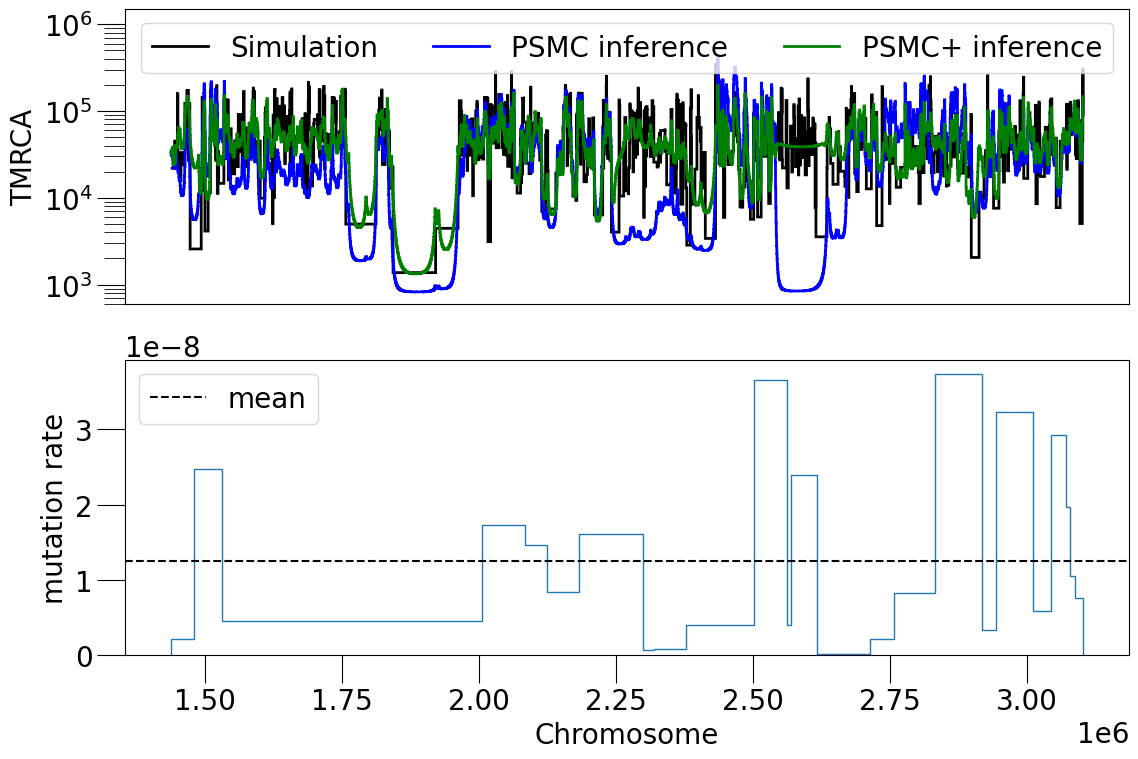

In [22]:
"""
Plot the simulated TMRCAs across the genome with the following inference of posterior means:
    1. simulation=constant_mutation_rate, inference=constant_mutation_rate, 
    2. simulation=varying_mutation_rate, inference=constant_mutation_rate, 
    3. simulation=varying_mutation_rate, inference=varying_mutation_rate, 
In the below subplot, show how the varying mutation rate varies across the genome 
"""
plt.rcParams.update({'font.size': 20})


# Simulated TMRCAS
plt.subplot(2,1,1)
zlinewidth = 2
coaldata = np.loadtxt('/home/trevor/testing_varyingmuPSMCplus/constpop_mu1.25e-08_r1e-08_L10000000.0_N20000.0_coal_230909.txt.gz')
breakpoints = np.concatenate([[0],coaldata[:,1]])
iTMRCA = coaldata[:,2]
start_index = 500
end_index = 1500
plt.stairs(edges=breakpoints[start_index:end_index],values=iTMRCA[start_index:end_index-1],linewidth=zlinewidth,color="black",baseline=None,label="Simulation")

# simulation=constant_mutation_rate, inference=constant_mutation_rate
decoding_file = '/home/trevor/testing_varyingmuPSMCplus/nvar.txt.gz'
decoding = np.loadtxt(decoding_file)
time_intervals = !zcat {decoding_file} | head -6 | tail -1 | less
ztheta = !zcat {decoding_file} | head -1
ztheta = float(ztheta[0].split(' ')[-1])
time_coalescent = np.array([float(i) for i in time_intervals[0][2:].split(',')])
zN = ztheta/(4*mean_mu)
time_gens = time_coalescent*2*zN
time_gens_midpoints = np.array([(time_gens[i]+time_gens[i+1])/2 for i in range(0,len(time_gens)-1)])
pos = decoding[0,:]
posterior = decoding[1:,:]
posterior_means = sum(posterior*time_gens_midpoints[:,np.newaxis])
start_bp = breakpoints[start_index]
end_bp = breakpoints[end_index]
zstart_index = np.where(pos< breakpoints[start_index])[0][-1]
zend_index = np.where(pos>breakpoints[end_index])[0][0]

# plt.stairs(edges=pos[zstart_index:zend_index],values=posterior_means[zstart_index:zend_index-1],linewidth=zlinewidth,color="blue",baseline=None,label="inference nvar")

# simulation=varying_mutation_rate, inference=constant_mutation_rate, 
decoding_file = '/home/trevor/testing_varyingmuPSMCplus/yvar.txt.gz'
decoding = np.loadtxt(decoding_file)
time_intervals = !zcat {decoding_file} | head -6 | tail -1 | less
ztheta = !zcat {decoding_file} | head -1
ztheta = float(ztheta[0].split(' ')[-1])
time_coalescent = np.array([float(i) for i in time_intervals[0][2:].split(',')])
zN = ztheta/(4*mean_mu)
time_gens = time_coalescent*2*zN
time_gens_midpoints = np.array([(time_gens[i]+time_gens[i+1])/2 for i in range(0,len(time_gens)-1)])
pos = decoding[0,:]
posterior = decoding[1:,:]
posterior_means = sum(posterior*time_gens_midpoints[:,np.newaxis])
start_bp = breakpoints[start_index]
end_bp = breakpoints[end_index]
zstart_index = np.where(pos< breakpoints[start_index])[0][-1]
zend_index = np.where(pos>breakpoints[end_index])[0][0]

plt.stairs(edges=pos[zstart_index:zend_index],values=posterior_means[zstart_index:zend_index-1],linewidth=zlinewidth,color="blue",baseline=None,label="PSMC inference")
plt.legend()
# plt.xlabel('Chromosome')
plt.ylabel('TMRCA')

# simulation=varying_mutation_rate, inference=varying_mutation_rate, 
decoding_file = '/home/trevor/testing_varyingmuPSMCplus/yvar_withMmap.txt.gz'
decoding = np.loadtxt(decoding_file)
time_intervals = !zcat {decoding_file} | head -6 | tail -1 | less
ztheta = !zcat {decoding_file} | head -1
ztheta = float(ztheta[0].split(' ')[-1])
time_coalescent = np.array([float(i) for i in time_intervals[0][2:].split(',')])
zN = ztheta/(4*mean_mu)
time_gens = time_coalescent*2*zN
time_gens_midpoints = np.array([(time_gens[i]+time_gens[i+1])/2 for i in range(0,len(time_gens)-1)])
pos = decoding[0,:]
posterior = decoding[1:,:]
posterior_means = sum(posterior*time_gens_midpoints[:,np.newaxis])
start_bp = breakpoints[start_index]
end_bp = breakpoints[end_index]
zstart_index = np.where(pos< breakpoints[start_index])[0][-1]
zend_index = np.where(pos>breakpoints[end_index])[0][0]

plt.stairs(edges=pos[zstart_index:zend_index],values=posterior_means[zstart_index:zend_index-1],linewidth=zlinewidth,color="green",linestyle="solid",baseline=None,label="PSMC+ inference")

plt.legend(ncol=3,loc="upper center")
plt.yscale('log')
plt.ylabel('TMRCA')
plt.xticks([])
plt.ylim(6e+2,1.5e+06)

plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=15)

plt.subplot(2,1,2)
zstart_index = np.where(mutationratemap.left>start_bp)[0][0]
zend_index = np.where(mutationratemap.left<end_bp)[0][-1]
plt.stairs(edges=mutationratemap.left[zstart_index:zend_index],values=mutationratemap.rate[zstart_index:zend_index-1],baseline=False)
# plt.yscale('log')
plt.xlabel('Chromosome')
plt.ylabel('mutation rate')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=15)
plt.axhline(mean_mu,color="black",linestyle="dashed",label="mean")
plt.tight_layout()
plt.legend()
plt.show()

## Inference of $N_e(t)$

In [23]:
# create mutation map (a mutation rate that varies across the genome, arbitrary parameters)

L = 1e+07
r = 1e-08

mean_mu = 6e-08
a=2
b=3


# visulaise mutation map density
# xdom = np.arange(0,1,0.01)
# pdf = beta.pdf(xdom,a,b)
# plt.plot(xdom,pdf)

lengthscale = 1e+05
breakpoints = [0]
qdist= 0
while qdist<L:
    qdist += np.random.exponential(scale=lengthscale)
    breakpoints.append(qdist)
breakpoints[-1]=L

mu = mean_mu

num_mu_samples = len(breakpoints)
mu_samples = np.random.beta(a,b,size=len(breakpoints)-1)
mu_samples = mu_samples/((a/(a+b))/mean_mu)
mutationratemap = msprime.RateMap(position=breakpoints, rate=mu_samples)
mu_over_r_yvar = np.mean(mu_samples)/r

np.savetxt(f'/home/trevor/testing_varyingmuPSMCplus/Nesim_mu_samples_a{a}b{b}_230909.txt',mu_samples)
np.savetxt(f'/home/trevor/testing_varyingmuPSMCplus/Nesim_breakpoints_a{a}b{b}_230909.txt',breakpoints)

In [24]:
# write the mutation map to a file that PSMCplus can use
# it is a bed file; 1st column is chrom, 2nd column is start position, 3rd column is end position, 4th column is the rate between the start and end (2nd and 3rd column, respectively)

starts = mutationratemap.left
ends = mutationratemap.right
rates = mutationratemap.rate/mean_mu
scaled_ratemap = np.zeros(shape=(len(starts),3))
scaled_ratemap[:,0] = starts
scaled_ratemap[:,1] = ends
scaled_ratemap[:,2] = rates
write_scaled_R_map(20,scaled_ratemap,f'/home/trevor/testing_varyingmuPSMCplus/Nesim_ratemap_a{a}b{b}_230909.txt')


saved scaled rate map to /home/trevor/testing_varyingmuPSMCplus/Nesim_ratemap_a2b3_230909.txt


In [25]:
# set parameters for simulation

D=64 
spread_1=0.1
spread_2=50
N_size = 2e+04

time_coalescent = time_intervals_fcn(D,spread_1,spread_2)
time_gens = time_coalescent*2*N_size
gen=29

N_array = np.ones(shape=(D))
N_array[0:3] = 1.3
N_array[3:30] = 0.3
N_array[30:45] = 1.6
N_array = N_array*N_size

ztheta = mean_mu*4*N_size


In [27]:
# simulate mhs files (this will take a couple minutes)

num_chroms = 20
num_replicates = 5
for chrom in range(0,num_chroms):
    print(f'on chrom={chrom}')
    for iteration in range(0,num_replicates):
#         print(f'\ton replicate={iteration}')
        demography = msprime.Demography()
        demography.add_population(name="human", description="standard human pop", initial_size=N_size)
        for i,j in enumerate(time_gens[0:-1]):
            demography.add_population_parameters_change(time=time_gens[i], initial_size=N_array[i])

        sim = msprime.sim_ancestry(samples=[msprime.SampleSet(num_samples=2, ploidy=1,population='human',time=0)],demography=demography,recombination_rate=r,sequence_length=L)
        msim_yvar = msprime.sim_mutations(sim, rate=mutationratemap) # add mutations
        msprime_hets_yvar = np.array([int(np.rint(var.site.position)) for var in msim_yvar.variants() if var.genotypes[0]!=var.genotypes[1]])

        mhsfilename_yvar = f'/home/trevor/testing_varyingmuPSMCplus/changingNe_chr{chrom}_rep{iteration}_a{a}b{b}_yvar.mhs' # mutation yes varying
        write_mhs(msprime_hets_yvar,mhsfilename_yvar,chrom)
#         print('',flush=True)
print('Done')

on chrom=0
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr0_rep0_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr0_rep1_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr0_rep2_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr0_rep3_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr0_rep4_a2b3_yvar.mhs
on chrom=1
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr1_rep0_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr1_rep1_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr1_rep2_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr1_rep3_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr1_rep4_a2b3_yvar.mhs
on chrom=2
	written mhs file

	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr16_rep4_a2b3_yvar.mhs
on chrom=17
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr17_rep0_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr17_rep1_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr17_rep2_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr17_rep3_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr17_rep4_a2b3_yvar.mhs
on chrom=18
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr18_rep0_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr18_rep1_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr18_rep2_a2b3_yvar.mhs
	written mhs file to /home/trevor/testing_varyingmuPSMCplus/changingNe_chr18_rep3_a2b3_yvar.mhs
	written mhs fil

In [ ]:
# run PSMC+ (submit to a farm, you could run locally but would take a few minutes)

for replicate in range(0,num_replicates):
    in_mhs_files = " ".join([f'/home/trevor/testing_varyingmuPSMCplus/changingNe_chr{chrom}_rep{replicate}_a{a}b{b}_yvar.mhs' for chrom in range(0,num_chroms)])
    in_rate_files = " ".join([f'/home/trevor/testing_varyingmuPSMCplus/Nesim_ratemap_a{a}b{b}_230909.txt' for chrom in range(0,num_chroms)])
    output_const = f'/home/trevor/testing_varyingmuPSMCplus/inference_assumeconst_changingNe_rep{replicate}_a{a}b{b}_'
    output_varyi = f'/home/trevor/testing_varyingmuPSMCplus/inference_varyingrate_changingNe_rep{replicate}_a{a}b{b}_'
    
    # inference assuming (incorrectly) constant mutation rate 
    commandline_const = f'python /home/trevor/PSMCplus/PSMCplus.py -in {in_mhs_files} -o {output_const} -D 64 -b 100 -spread_1 0.1 -spread_2 50 -theta {ztheta} -mu_over_rho_ratio {mu_over_r_yvar} -its 20 -thresh 1| tee {output_const}_log.txt'
    slurmsubmission_const = f'sbatch --wrap="{commandline_const}" -p short --mem-per-cpu=5G -t 00:30:00 -c 12'
    !{slurmsubmission_const}

    # inference using varying mutation rate 
    commandline_varyi = f'python /home/trevor/PSMCplus/PSMCplus.py -in {in_mhs_files} -in_M {in_rate_files} -o {output_varyi} -D 64 -b 100 -spread_1 0.1 -spread_2 50 -theta {ztheta} -mu_over_rho_ratio {mu_over_r_yvar} -its 20 -thresh 1 | tee {output_varyi}_log.txt'
    slurmsubmission_varyi = f'sbatch --wrap="{commandline_varyi}" -p short --mem-per-cpu=5G -t 00:30:00 -c 12'
    !{slurmsubmission_varyi}



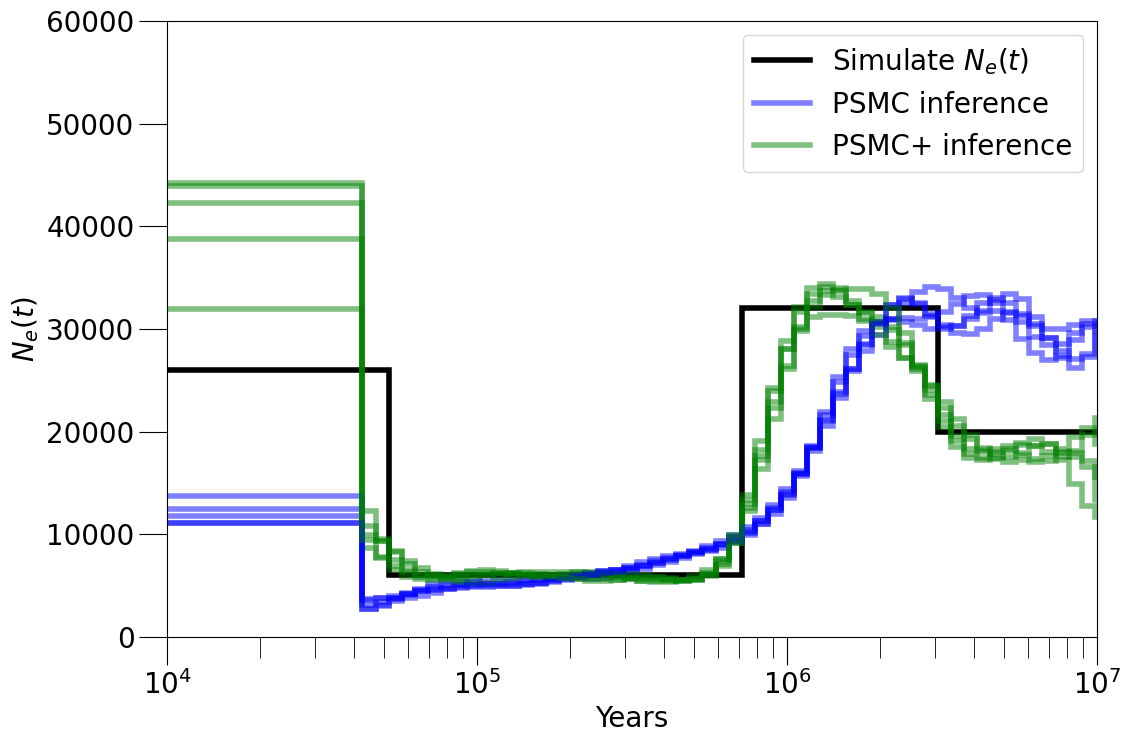

In [29]:
time_years = time_gens*gen

plt.stairs(edges=time_years,values=N_array,label="Simulate $N_e(t)$",baseline=None,linewidth=4,color="black")
for rep in range(0,num_replicates):
    
    const_file = f'/home/trevor/testing_varyingmuPSMCplus/copyme/inference_assumeconst_changingNe_rep{rep}_a{a}b{b}_final_parameters.txt'
    final_params = np.loadtxt(const_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    if rep==1:
        zlab = 'PSMC inference'
    else:
        zlab = ''
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,color="blue",label=zlab,linewidth=4,linestyle="solid",baseline=None,alpha=0.5)
    
    
    varyi_file = f'/home/trevor/testing_varyingmuPSMCplus/copyme/inference_varyingrate_changingNe_rep{rep}_a{a}b{b}_final_parameters.txt'
    final_params = np.loadtxt(varyi_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    if rep==1:
        zlab = 'PSMC+ inference'
    else:
        zlab = ''
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,color="green",label=zlab,linewidth=4,linestyle="solid",baseline=None,alpha=0.5)

    
plt.xlabel('Years')
plt.xlim(1e+04,1e+07)
plt.ylim(0,6e+04)
plt.xscale('log')
plt.ylabel('$N_e(t)$')
plt.legend()
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=15)